<h3>Loading dataset</h3>

In [2]:
import pandas as pd
import numpy as np

# import csv
df = pd.read_csv('modified_dataset.csv', 
                 dtype={'Temperature':str, 
                        'Pressure0':str, 
                        'Humidity':str, 
                        'Wind_speed':str}, 
                 delimiter=';', 
                 na_filter=False)
df.head()

,Time,Temperature,Pressure0,Pressure,Humidity,Wind_speed,mist,Unnamed: 7,snow,rain,...,Wind_direction_variable,Wind_direction_west,Wind_direction_west-northwest,Wind_direction_west-southwest,Cloud_,Cloud_broken clouds,Cloud_few clouds,Cloud_no significant clouds,Cloud_overcast,Cloud_scattered clouds
0,1420070400,-12,762.5,777.7,85,2,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,1420072200,-11,761.9,777.0,85,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1420074000,-10,761.9,777.0,85,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1420075800,-10,761.9,777.0,85,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1420077600,-9,762,777.0,79,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<h3>Preparing input and output sequence</h3>

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [4]:
X = np.array(df.loc[:,(df.columns != 'Time')].values)
Y = np.array(df['Temperature'])
X = X[:-1]
Y = Y[1:]

In [5]:
for idx, val in enumerate(X[:,0]):
    if val=='':
        X[:,0][idx] = (np.float64(X[:,0][idx-1])+np.float64(X[:,0][idx+1]))/2
    else:
        X[:,0][idx] = np.float64(val)
        
for idx, val in enumerate(X[:,1]):
    if val=='':
        X[:,1][idx] = (np.float64(X[:,1][idx-1])+np.float64(X[:,1][idx+1]))/2
    else:
        X[:,1][idx] = np.float64(val)
        

for idx, val in enumerate(X[:,2]):
    if val=='':
        X[:,2][idx] = (int(X[:,2][idx-1])+int(X[:,2][idx+1]))/2
    else:
        X[:,2][idx] = int(val)
        
for idx, val in enumerate(X[:,3]):
    if val=='':
        X[:,3][idx] = (int(X[:,3][idx-1])+int(X[:,3][idx+1]))/2
    else:
        X[:,3][idx] = int(val)
        
for idx, val in enumerate(X[:,4]):
    if val=='':
        X[:,4][idx] = (int(X[:,4][idx-1])+int(X[:,4][idx+1]))/2
    else:
        X[:,4][idx] = int(val)
        
for idx, val in enumerate(Y):
    if val=='':
        Y[idx] = (int(Y[idx-1])+int(Y[idx+1]))/2
    else:
        Y[idx] = int(val)

Y2=np.zeros((63133,2), dtype='float64')
Y2[0:63133, 1] = Y[0:63133]
Y2[0:63133, 0] = Y[1:63134]

X2 = X[1:63134,:]

X=X2
Y=Y2

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.layers import LSTM

Using TensorFlow backend.


<h3>Preprocessing data</h3>

In [7]:
nb_samples = len(X)
test_split = 0.2
# splitting train-validation-test sets
X_train = X[0:int(nb_samples*(1-test_split))]
Y_train = Y[0:int(nb_samples*(1-test_split))]
X_test  = X[int(nb_samples*(1-test_split)):]
Y_test  = Y[int(nb_samples*(1-test_split)):]

# standardizing
scaler = preprocessing.StandardScaler().fit(X_train)

from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

(50506, 40)
(50506, 2)


C:\Users\admin\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<h3>Loss function definition</h3>

In [22]:
import keras.backend as K
#print(np.max(Y_train[0:,0]-Y_train[0:,1]))

def vori(y_true, y_pred):
    mse= K.square(K.tf.subtract(y_true[:,0], y_pred))
    constr1 = K.maximum(K.tf.subtract(K.abs(K.tf.subtract(y_true[:,1], y_pred)),
                     K.constant(value=12.0, dtype = 'float32')),
                     K.constant(value= 0.0, dtype = 'float32'))
    
    return(K.mean(mse+constr1))


#regm.compile(optimizer=adam, loss=[AAD_loss(1.0)], metrics=['accuracy']) 

<h3>Model definition</h3>

In [23]:
def model():
    model = Sequential()
    model.add(Dense(4, input_dim=40, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=vori, optimizer='adam')
    return model

<h3> Training </h3>

In [24]:
estimator = KerasRegressor(build_fn=model, epochs=25, batch_size=16,verbose=1)
history = estimator.fit(X_train, Y_train)

Tensor("loss_1/dense_6_loss/Square:0", shape=(?, ?), dtype=float32)
Tensor("loss_1/dense_6_loss/Maximum:0", shape=(?, ?), dtype=float32)
Epoch 1/25
50506/50506 [==============================] - 6s 120us/step - loss: 178.1780
Epoch 2/25
50506/50506 [==============================] - 5s 103us/step - loss: 135.3313
Epoch 3/25
50506/50506 [==============================] - 5s 102us/step - loss: 110.2803
Epoch 4/25
50506/50506 [==============================] - 5s 104us/step - loss: 99.0333
Epoch 5/25
50506/50506 [==============================] - 5s 100us/step - loss: 95.9884
Epoch 6/25
50506/50506 [==============================] - 5s 100us/step - loss: 95.5968
Epoch 7/25
50506/50506 [==============================] - 5s 105us/step - loss: 95.5651
Epoch 8/25
50506/50506 [==============================] - 5s 100us/step - loss: 95.4997
Epoch 9/25
50506/50506 [==============================] - 5s 99us/step - loss: 95.4282
Epoch 10/25
50506/50506 [==============================] - 6s 109us/s

In [11]:
estimator.model.save('saved_model.h5')

<h3>Predicting</h3>

In [12]:
pred = estimator.predict(X_test)

12627/12627 [==============================] - 0s 28us/step


In [13]:
print(history.history.keys())
print(pred[:10])

dict_keys(['loss'])
[10.247485  10.510536  10.510536  10.426312  10.41909   10.301503
 10.370148  10.308588  10.1502075 10.120849 ]


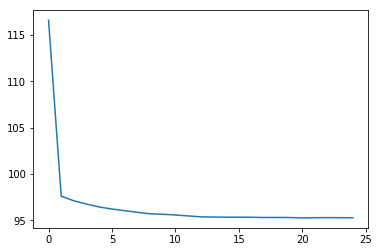

In [14]:
plt.plot(history.history['loss'])
plt.show()

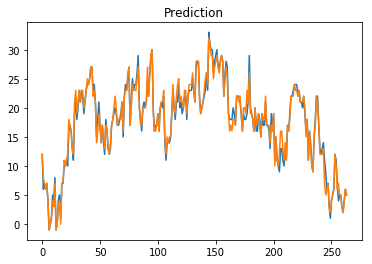

In [15]:
plt.plot(Y_test[::48])
#plt.plot(pred[::48])
plt.title('Prediction')
plt.show()

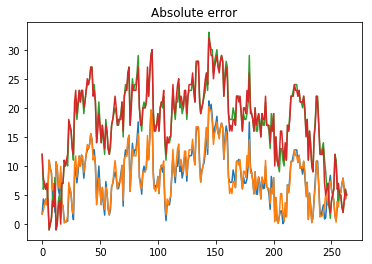

In [16]:
c = []

for i in range(len(Y_test)):
    c.append(abs(pred[i] - Y_test[i]))
    
plt.plot(c[::48])
plt.plot(Y_test[::48])
plt.title('Absolute error')
plt.show()

In [17]:
import re
import pandas as pd
import numpy as np
from sklearn import preprocessing

df = pd.read_csv('modified_dataset.csv', dtype={'Temperature':str, 'Pressure0':str, 'Humidity':str, 'Wind_speed':str}, delimiter=';', na_filter=False)

from sklearn.externals import joblib
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 


array_test = []
phenomena = ['mist', '', 'snow', 'rain', 'fog', 'shower', 'drizzle', 'squall', 'thunderstorm', 'hail']

df_test = pd.read_csv('test.csv', dtype={'Temperature':str, 'Pressure0':str, 'Humidity':str, 'Wind_speed':str}, delimiter=',',skipinitialspace=True,  na_filter=False)
exp = '[rR]ain|[fF]og|[tT]hunderstorm|[sS]now|[hH]ail|[mM]ist|[Ss]hower|[Dd]rizzle|[Ss]quall'
exp_wind = '(Wind blowing from the )|( wind direction)|(Calm, )'
l = 0
for idx in df_test.index:
    df_test.at[idx, 'Wind_direction'] = re.sub(exp_wind, '', df_test.at[idx, 'Wind_direction'])
    df_test.at[idx, 'Phenomena'] = (', '.join(re.findall(exp, df_test.at[idx, 'Phenomena']))).lower()
    df_test.at[idx, 'Cloud'] = df_test.at[idx, 'Cloud'].split(' (')[0].split('Vertical')[0].lower()

for word in phenomena:
    array_test.append([])
    for line in df_test['Phenomena']:
        separated = line.replace(" ", "").split(',')
        if word in separated:
            array_test[l].append(1)
        else:
            array_test[l].append(0)
    l+=1
        
for l in range(len(array_test)):
    df_test[phenomena[l]] = array_test[l]

df_test = df_test.drop('Phenomena', axis=1)



df_test = pd.get_dummies(df_test, columns=["Wind_direction","Cloud"])

arr = np.zeros(len(df_test))


for column in df:
    if column not in df_test:
        df_test[column] = arr
        
columnsTitles = df.columns.values
df_test = df_test.reindex(columns=columnsTitles)

df_test.to_csv (r'modified_testset.csv', index = None, header=True, sep=';')

In [18]:
XPRED = np.array(df_test.loc[:, (df_test.columns != 'Time')].values)
YPRED = np.array(df_test['Temperature'])

XPRED = XPRED[:-1]
YPRED = YPRED[1:]

    
for idx, val in enumerate(XPRED[:,0]):
    if val=='':
        XPRED[:,0][idx] = (np.float64(XPRED[:,0][idx-1])+np.float64(XPRED[:,0][idx+1]))/2
    else:
        XPRED[:,0][idx] = np.float64(val)

for idx, val in enumerate(XPRED[:,1]):
    if val=='':
        XPRED[:,1][idx] = (np.float64(XPRED[:,1][idx-1])+np.float64(XPRED[:,1][idx+1]))/2
    else:
        XPRED[:,1][idx] = np.float64(val)


for idx, val in enumerate(XPRED[:,2]):
    if val=='':
        XPRED[:,2][idx] = (int(XPRED[:,2][idx-1])+int(XPRED[:,2][idx+1]))/2
    else:
        XPRED[:,2][idx] = int(val)

for idx, val in enumerate(XPRED[:,4]):
    if val=='':
        XPRED[:,4][idx] = (int(XPRED[:,4][idx-1])+int(XPRED[:,4][idx+1]))/2
    else:
        XPRED[:,4][idx] = int(val)

#print(YPRED[0])

XPRED = scaler.transform(XPRED)

C:\Users\admin\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
eredmeny = estimator.predict(XPRED)

95/95 [==============================] - 0s 178us/step


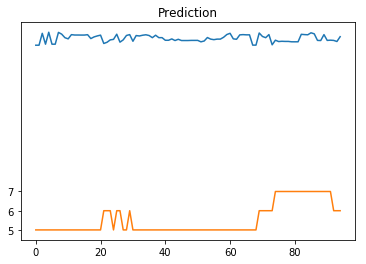

In [20]:
import matplotlib.pyplot as plt

plt.plot(eredmeny)
plt.plot(YPRED)
plt.title('Prediction')
plt.show()

In [21]:
for i in range (len(eredmeny)):
    print("predicted: ", "%.1f"%eredmeny[i], " real: " ,YPRED[i])

predicted:  9.6  real:  5
predicted:  9.6  real:  5
predicted:  10.2  real:  5
predicted:  9.7  real:  5
predicted:  10.3  real:  5
predicted:  9.7  real:  5
predicted:  9.7  real:  5
predicted:  10.3  real:  5
predicted:  10.2  real:  5
predicted:  10.0  real:  5
predicted:  9.9  real:  5
predicted:  10.2  real:  5
predicted:  10.1  real:  5
predicted:  10.1  real:  5
predicted:  10.1  real:  5
predicted:  10.1  real:  5
predicted:  10.2  real:  5
predicted:  10.0  real:  5
predicted:  10.0  real:  5
predicted:  10.1  real:  5
predicted:  10.1  real:  5
predicted:  9.7  real:  6
predicted:  9.8  real:  6
predicted:  9.9  real:  6
predicted:  9.9  real:  5
predicted:  10.2  real:  6
predicted:  9.8  real:  6
predicted:  9.9  real:  5
predicted:  10.1  real:  5
predicted:  10.2  real:  6
predicted:  9.8  real:  5
predicted:  10.1  real:  5
predicted:  10.1  real:  5
predicted:  10.1  real:  5
predicted:  10.2  real:  5
predicted:  10.1  real:  5
predicted:  10.0  real:  5
predicted:  10